# Map fields for p125 model 

In [1]:
# Stephen.Griffies@noaa.gov
# To be run on the GFDL analysis machine due to large file sizes. 

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import cmocean
import cartopy.crs as ccrs
import mplsettings

from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

In [4]:
# 1/8th static file for area and weights 

fname_static = "/net/smg/OWG/CM4_highres/grids/p125/ocean_annual.static.nc"
static       = xr.open_mfdataset(fname_static)
areacello    = static['areacello']
wet          = static['wet']
area         = areacello*wet
areatotal    = area.sum(dim=["xh", "yh"])
weight       = area/areatotal
#areatotal.values
#weight.sum(dim=["xh", "yh"])
#area.plot(x='geolon',y='geolat',cmap=cmocean.cm.rain)

In [5]:
# dataset all months.  ignore different length of months to produce 30-year mean  

dir_ds = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_monthly/ts/monthly/5yr"

files  = [dir_ds+"/ocean_monthly.198001-198412.Rd_dx.nc", 
          dir_ds+"/ocean_monthly.198501-198912.Rd_dx.nc", 
          dir_ds+"/ocean_monthly.199001-199412.Rd_dx.nc",
          dir_ds+"/ocean_monthly.199501-199912.Rd_dx.nc", 
          dir_ds+"/ocean_monthly.200001-200412.Rd_dx.nc",
          dir_ds+"/ocean_monthly.200501-200912.Rd_dx.nc"] 
dset = xr.open_mfdataset(files)
dset = dset.assign_coords({'geolon': static['geolon'], 'geolat': static['geolat']})
Rd_dx = dset['Rd_dx']

filesRd1 = [dir_ds+"/ocean_monthly.198001-198412.Rd1.nc", 
            dir_ds+"/ocean_monthly.198501-198912.Rd1.nc", 
            dir_ds+"/ocean_monthly.199001-199412.Rd1.nc",
            dir_ds+"/ocean_monthly.199501-199912.Rd1.nc", 
            dir_ds+"/ocean_monthly.200001-200412.Rd1.nc",
            dir_ds+"/ocean_monthly.200501-200912.Rd1.nc"] 
dsetRd1 = xr.open_mfdataset(filesRd1)
dsetRd1 = dsetRd1.assign_coords({'geolon': static['geolon'], 'geolat': static['geolat']})
Rd1     = dsetRd1['Rd1']

Rd_dx.load()
Rd1.load()

In [6]:
# compute the time mean, taking into account the number of days in a month 

field = Rd_dx

month_length = field.time.dt.days_in_month
wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)
wgts.groupby("time.year").sum(xr.ALL_DIMS)

cond = field.isnull()
ones = xr.where(cond, 0.0, 1.0)

field_sum = (field * wgts).resample(time="AS").sum(dim="time")
ones_sum = (ones * wgts).resample(time="AS").sum(dim="time")

field_ann = field_sum / ones_sum
Rd_dx_climate = field_ann.mean(dim="time")

Rd_dx_climate.load()

<xarray.DataArray (yh: 2240, xh: 2880)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * xh       (xh) float64 -298.6 -298.5 -298.4 -298.3 ... 61.05 61.16 61.28
  * yh       (yh) float64 -83.62 -83.58 -83.54 -83.5 ... 89.81 89.86 89.92 89.97
    geolon   (yh, xh) float32 -298.6 -298.5 -298.4 -298.2 ... 60.0 60.0 60.0
    geolat   (yh, xh) float32 -82.46 -82.46 -82.45 -82.45 ... 64.17 64.11 64.06

In [7]:
# compute the time mean, taking into account the number of days in a month 

field2 = Rd1

cond2 = field2.isnull()
ones2 = xr.where(cond2, 0.0, 1.0)

field2_sum = (field2 * wgts).resample(time="AS").sum(dim="time")
ones2_sum = (ones2 * wgts).resample(time="AS").sum(dim="time")

field2_ann  = field2_sum / ones2_sum
Rd1_climate = field2_ann.mean(dim="time")

Rd1_climate.load()

<xarray.DataArray (yh: 2240, xh: 2880)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * xh       (xh) float64 -298.6 -298.5 -298.4 -298.3 ... 61.05 61.16 61.28
  * yh       (yh) float64 -83.62 -83.58 -83.54 -83.5 ... 89.81 89.86 89.92 89.97
    geolon   (yh, xh) float32 -298.6 -298.5 -298.4 -298.2 ... 60.0 60.0 60.0
    geolat   (yh, xh) float32 -82.46 -82.46 -82.45 -82.45 ... 64.17 64.11 64.06

In [11]:
# save data to netCDF 
Rd1_climate.to_netcdf("CM4Xp125_Rd1_30year.nc")
Rd_dx_climate.to_netcdf("CM4Xp125_Rd_dx_30year.nc")

In [8]:
area_2 = area.where(Rd_dx_climate > 2.0)
frac_2 = area_2.sum(dim=["xh", "yh"])/areatotal
print('fraction of area with Rd_dx > 2.0 is ',frac_2.values)

fraction of area with Rd_dx > 2.0 is  0.53648376


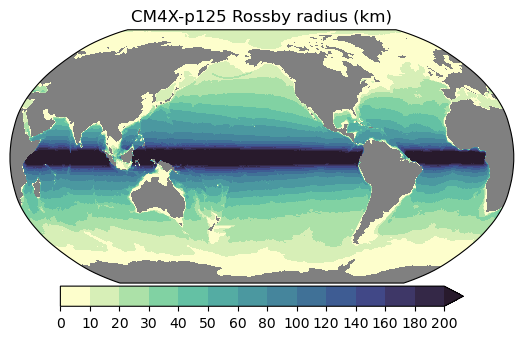

In [9]:
#Map the Rossby radius 

#field = np.log10(Rd_dx)
field = Rd1_climate/1000
vmin = 0.
vmax = 200
ticks = [0, 10, 20, 30, 40, 50, 60, 80, 100, 120, 140, 160, 180, 200]  # Custom tick positions
levels= [0, 10, 20, 30, 40, 50, 60, 80, 100, 120, 140, 160, 180, 200]  # Custom level positions
numticks = len(ticks)

fig, axis = plt.subplots(ncols=1, nrows=1, figsize=(6.5,4.0),
             subplot_kw={'projection': ccrs.Robinson(central_longitude=-150)})

p=xr.plot.contourf(field, ax=axis, 
                     x='geolon',y='geolat',
                     vmin=vmin, vmax=vmax,
                     transform=ccrs.PlateCarree(), 
                     cmap=cmocean.cm.deep,
                     add_colorbar=False,
                     levels=levels
                    ) 
#p=xr.plot.pcolormesh(field, ax=axis, 
#                     x='geolon',y='geolat',
#                     vmin=vmin, vmax=vmax,
#                     transform=ccrs.PlateCarree(), 
#                     cmap=cmocean.cm.deep,
#                     add_colorbar=False
#                    ) 


plt.gca().set_facecolor('gray')
plt.tick_params(labelsize=10) 
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('CM4X-p125 Rossby radius (km)', fontsize=12)
cbar = plt.colorbar(p,pad=0.01,spacing='uniform', extend='both', shrink=0.80, orientation='horizontal')
cbar.set_ticks(ticks)

plt.show()

fig.savefig('CM4Xp125_Rd1_30year.jpg', format='jpeg', bbox_inches='tight', dpi=400)

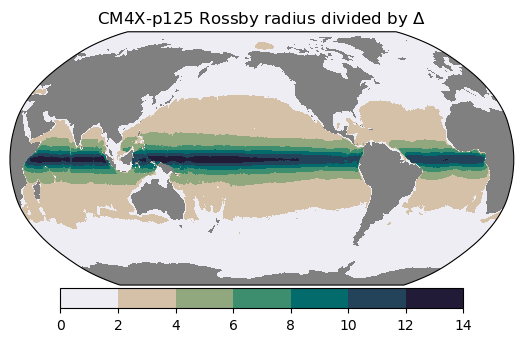

In [10]:
#Map the Rossby radius divided by grid spacing

field = Rd_dx_climate
vmin = 0.
vmax = 14
levels= [0, 2, 4, 6, 8, 10, 12, 14]  # Custom level positions
#levels= [0, .5, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Custom level positions
levels2 = [0, 2] # for contours 


fig, axis = plt.subplots(ncols=1, nrows=1, figsize=(6.5,4.0),
           subplot_kw={'projection': ccrs.Robinson(central_longitude=-150)}
                        )
p = field.plot.contourf(
           transform=ccrs.PlateCarree(),
           x='geolon',y='geolat',
           vmin=vmin, vmax=vmax,
           cmap=cmocean.cm.rain,
           add_colorbar=False,
           levels=levels
           )
#p = field.plot.contour(
#           transform=ccrs.PlateCarree(),
#           x='geolon',y='geolat',
#           vmin=vmin, vmax=vmax,
#           levels=levels2
#           )


plt.gca().set_facecolor('gray')
plt.tick_params(labelsize=12) 
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('CM4X-p125 Rossby radius divided by $\Delta$', fontsize=12)
cbar = plt.colorbar(p,pad=0.01,spacing='uniform', extend='both', shrink=0.80,orientation='horizontal')
plt.show()

fig.savefig('CM4Xp125_Rd_dx_30year.jpg', format='jpeg', bbox_inches='tight', dpi=400)